# Improving Classfication performance on STEAD dataset

In [1]:
from EQDataset import EQDataset
from NoiseDataset import NoiseDataset
import numpy as np
import torch 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import ConcatDataset, DataLoader, random_split
import pandas as pd
import h5py

from obspy.clients.fdsn import Client

from obspy import UTCDateTime

import seisbench.models as sbm

from phasenet import PhaseNet


In [2]:
csv_file_eq = '..//data//chunk5.csv'
file_name_eq = '..//data//chunk5.hdf5'

csv_file_noise = '..//data//chunk1.csv'
file_name_noise = '..//data//chunk1.hdf5'

Structure of the dataset: \
We want earthquakes and noise waves to appear in the same dataset, this shouldnt be separated

In [6]:
batch_size = 64

In [15]:
cl = 136
eq_dataset = EQDataset(csv_file_eq, file_name_eq, tri_width=10, transform=True, cutting_length=cl)
noise_dataset = NoiseDataset(csv_file_noise, file_name_noise, transform=True, cutting_length=cl)

datasets = [eq_dataset, noise_dataset]

dataset = ConcatDataset(datasets)

train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7,0.15, 0.15])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=10)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

5min 2500
1min 610 (3050)
8 workers 1min (with 10sec init) 1390
10 workers 1min (with 10sec init) 1450

In [8]:
pn_model_standard = PhaseNet()
for i, sample in enumerate(train_dataloader):
    print(sample[0].shape)
    waveform, labels = sample
    res = pn_model_standard(waveform.unsqueeze(1))
    break

torch.Size([64, 5864])


In [28]:
pt_model = sbm.PhaseNet.from_pretrained("stead")
#layer_stead = nn.Conv1d(1, 8, 7, padding='same', stride=(1,))
#layer_stead.weight.data = pn_model.inc.weight.data[:,0,:].unsqueeze(1)
#pn_model.inc = layer_stead 
#pn_model.in_channels = 1

In [5]:
pn_model = PhaseNet()
pn_model

PhaseNet(
  (inc): Conv1d(1, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [6]:
for i, sample in enumerate(train_dataloader):
    print(sample[0].shape)
    waveform, labels = sample
    res = pn_model(waveform.unsqueeze(1))
    break

torch.Size([64, 5900])
1 torch.Size([64, 8, 5900])
2 torch.Size([64, 8, 5900])
3 torch.Size([64, 16, 1475])
4 torch.Size([64, 32, 369])
5 torch.Size([64, 64, 92])
6 torch.Size([64, 128, 23])
first for loop done
0 torch.Size([64, 128, 23])
torch.Size([64, 64, 92])
torch.Size([64, 128, 92])
1 torch.Size([64, 64, 92])
torch.Size([64, 32, 368])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 369 but got size 1 for tensor number 1 in the list.

In [16]:
# Initialize default parameters
epochs = 100
learning_rate = 1e-1

# Initialize datasets and dataloaders
train_loader = train_dataloader

# Initialize the model and optimizer
device = torch.device("mps")
model = PhaseNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction = 'sum')  # Replace with your loss function

In [28]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs, logits=True)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().detach().numpy() / inputs.shape[0]
        if (not i%1000):
            print(i, train_loss) 
            
    print(f"End of Epoch Training loss {train_loss / len(train_dataloader)}")
            
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)
            outputs = model(inputs, logits=True)
            val_loss += criterion(outputs, labels) / inputs.shape[0]
        
        print(f'Validation loss for epoch {epoch}: ', val_loss / len(val_dataloader))
        

0 27.62689971923828
1000 24874.299083709717
2000 49419.8737783432
3000 74273.48527145386
4000 98755.82191848755
End of Epoch Training loss 24.667276921311387
Validation loss for epoch 0:  tensor(24.3202, device='mps:0')
0 25.715133666992188
1000 24390.353103637695
2000 48772.94949436188
3000 73060.91477775574
4000 97330.1328792572
End of Epoch Training loss 24.28697197605847
Validation loss for epoch 1:  tensor(24.1162, device='mps:0')
0 16.84685516357422
1000 24125.684136390686
2000 48195.94641304016
3000 72594.97463226318
4000 96504.11778068542
End of Epoch Training loss 24.069189087692695
Validation loss for epoch 2:  tensor(23.9172, device='mps:0')
0 26.490745544433594
1000 24204.020115852356
2000 48052.66706466675
3000 71723.95133495331
4000 95473.61246109009
End of Epoch Training loss 23.849125644812265
Validation loss for epoch 3:  tensor(23.8982, device='mps:0')
0 27.459095001220703
1000 23822.138266563416
2000 47690.78364944458
3000 71273.01214408875
4000 94837.03951263428
End

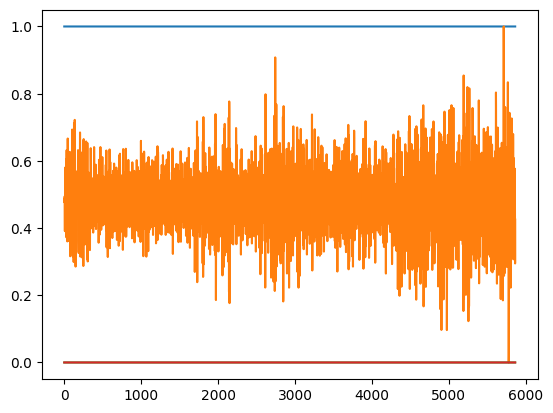

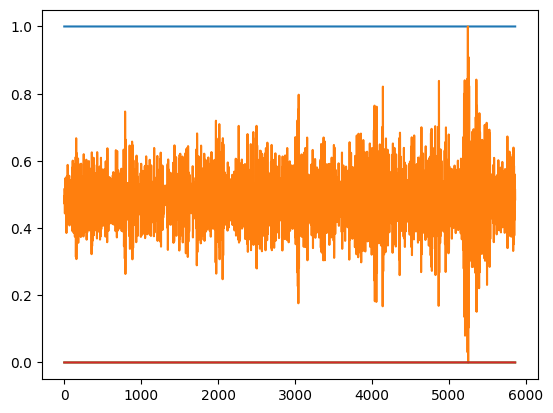

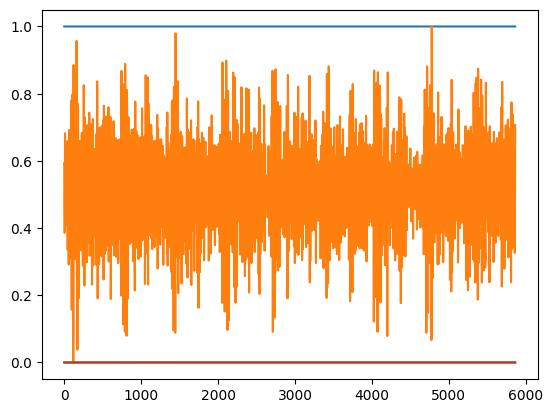

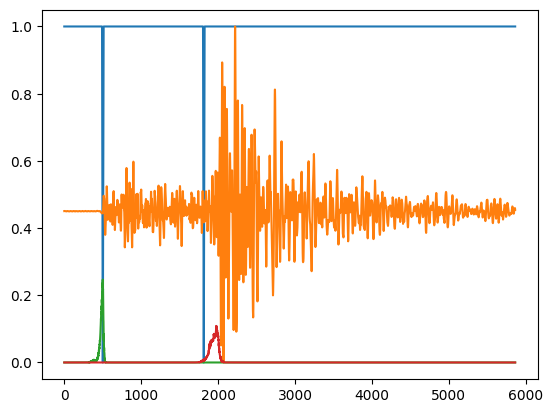

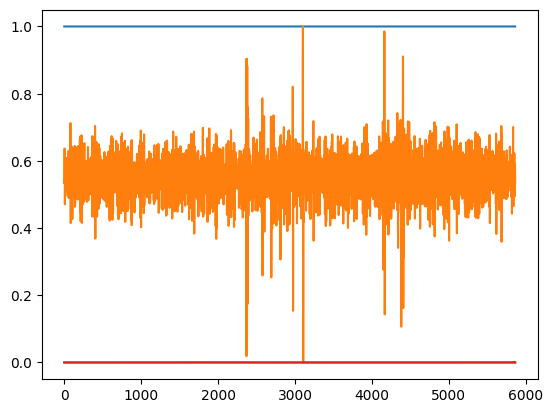

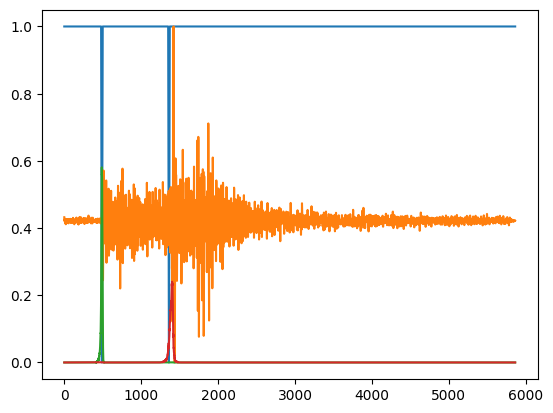

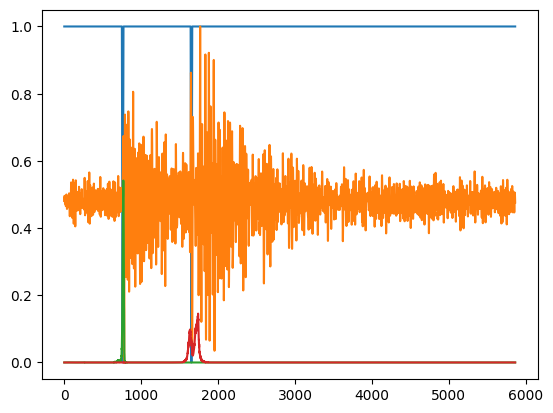

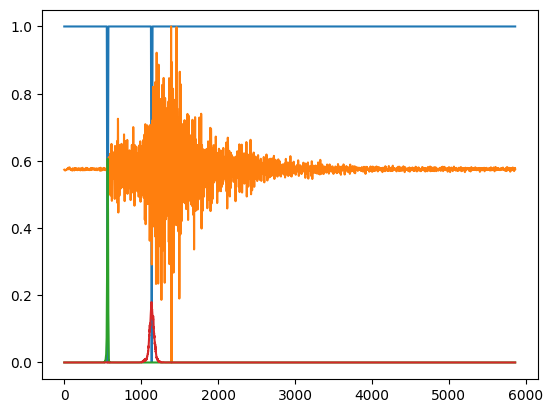

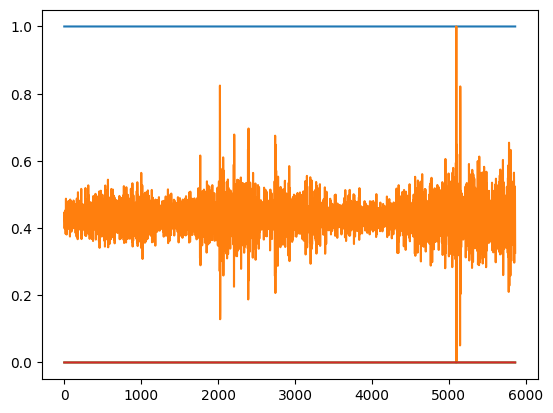

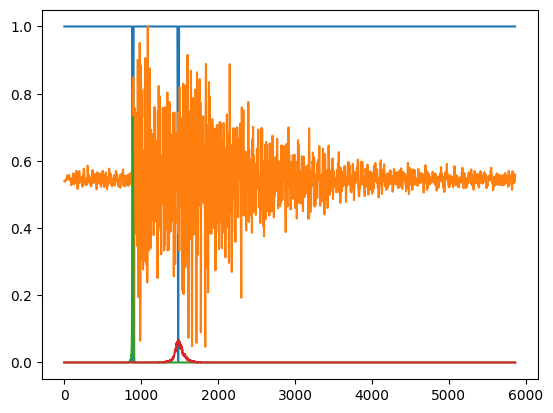

In [26]:
val_loss = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        if (i > 10):
            inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)
            outputs = model(inputs)
            plt.plot(labels.cpu().detach().numpy()[0, 2, :])
            plt.plot(inputs.cpu().detach().numpy()[0, 0, :])
            plt.plot(outputs.cpu().detach().numpy()[0,0,:])
            plt.plot(outputs.cpu().detach().numpy()[0,1,:])
            #val_loss += criterion(outputs, labels) / inputs.shape[0]
            plt.show()
            if (i == 20): break
    
    #print(f'Validation loss for epoch {0}: ', val_loss / len(val_dataloader))

In [29]:
val_loss = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs
        outputs = pt_model(inputs)
        plt.plot(inputs.detach().numpy()[0, 0, :])
        plt.plot(outputs.detach().numpy()[0,0,:])
        plt.plot(outputs.detach().numpy()[0,1,:])
        #val_loss += criterion(outputs, labels) / inputs.shape[0]
        
        break

RuntimeError: Given groups=1, weight of size [8, 3, 7], expected input[64, 1, 6000] to have 3 channels, but got 1 channels instead